Copyright (C) 2023 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

### Unsupervised Clustering for HCS Plate with omero2pandas

This notebook demonstrates how to retrieve analytical data stored as an [OMERO.table](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) from the [OMERO.server](https://www.glencoesoftware.com/products/omeroplus/) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas) and build unsupervised clustering model to profile the cells.

The example below uses the output of the image processing performed using [OMERO-Segmentation Connector for HCS](https://www.glencoesoftware.com/solutions/digital-pathology/) which utilizes [CellProfiler](https://github.com/stardist/stardist) as a segmenter. Derived features (parameters describing cells' shape, intensity and neighborhood) are then used to build a clustering model using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html). Finally the cluster ids are assigned to each object and saved to [OMERO.tables](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas). The stored data can be visualized remotely with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/).

##### Workflow
 * Load OMERO.table to Pandas DataFrame using omero2pandas
 * Pre-process the data (replace missing values, normalize, etc.)
 * Remove strongly correlated features using Spearman correlation
 * Run dimensionality reduction using UMAP
 * Build an unsupervised clustering model and classify the cells
 * Visualize the results using Datashader, Bokeh, and HoloViews
 * Save the result to OMERO.tables for visualization with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/), or other downstream workflows

#### Define variables and OMERO IDs that will be used for the next steps

In [61]:
# Define the image and table IDs
# Plate ID will be used to link the uploaded table to the image
PLATE_ID = 53
# Table ID
TABLE_FILE_ID = 18534
METADATA_TABLE_FILE_ID = 18546

# Where to store the downloaded table?
table_path = "./plate_objects.csv"
metadata_table_path = "./plate_metadata.csv"
# The name will be used as OMERO.table name
output_table_name = "Unsupervised_clustering_result"
# Store outputs locally
output_table_path = f"{output_table_name}.csv"

### Imports

In [62]:
%%capture
import logging

numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

from umap import UMAP

In [63]:
%%capture

import os
import pandas as pd
import omero2pandas
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from umap import UMAP
from sklearn.decomposition import PCA
import holoviews as hv
import holoviews.operation.datashader as hd
from bokeh.models import HoverTool
from holoviews import opts
import datashader as ds
from matplotlib.colors import ListedColormap
from bokeh.palettes import Viridis256
from bokeh.plotting import show

hv.extension('bokeh')

In [64]:
import skimage.exposure
import shapely
import shapely.wkt
import math
import shapely.affinity
import matplotlib.pyplot as plt

#### Load the table from OMERO and save it locally for future us

If [omero-user-token](https://github.com/glencoesoftware/omero-user-token) is installed and valid [omero2pandas](https://github.com/glencoesoftware/omero2pandas) will use it automatically for the OMERO.server connection otherwise it will ask for the connection details.

##### Without omero-user-token

In [65]:
import omero2pandas

In [66]:
# Initialize Connector
connector = omero2pandas.connect_to_omero()

Output()

In [68]:
# Load the data
if not os.path.exists(table_path):
    omero2pandas.download_table(
        table_path, file_id=TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

File exists not downloading


In [140]:
# From dist, needs to be switched to omero2pandas
df = pd.read_csv(table_path)

In [70]:
# Load metadata
if not os.path.exists(metadata_table_path):
    omero2pandas.download_table(
        metadata_table_path, file_id=METADATA_TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

File exists not downloading


In [141]:
metadata_df = pd.read_csv(metadata_table_path)

In [111]:
df.head()

,Unnamed: 0,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_MaxIntensity_Y_DNA,Location_MaxIntensity_Z_DNA,Neighbors_AngleBetweenNeighbors_Expanded,Neighbors_FirstClosestDistance_Expanded,Neighbors_FirstClosestObjectNumber_Expanded,Neighbors_NumberOfNeighbors_Expanded,Neighbors_PercentTouching_Expanded,Neighbors_SecondClosestDistance_Expanded,Neighbors_SecondClosestObjectNumber_Expanded,Number_Object_Number
0,0,1,222,289,147,18,130,1,138.135135,8.990991,...,10.0,0.0,38.073075,19.761976,2,5.0,73.308271,76.654564,54,1
1,1,2,470,625,132,29,107,4,119.774468,16.300000,...,12.0,0.0,130.646707,19.761976,1,4.0,75.757576,62.300959,54,2
2,2,3,181,238,891,22,874,8,881.972376,14.176796,...,13.0,0.0,27.276666,21.278161,16,4.0,68.725869,28.305380,26,3
3,3,4,306,396,1044,27,1026,5,1034.408497,15.379085,...,14.0,0.0,24.028088,18.598267,17,4.0,65.465465,61.751120,56,4
4,4,5,194,255,770,23,755,6,761.855670,14.175258,...,14.0,0.0,3.702548,23.753242,7,4.0,68.556701,42.579682,8,5


In [147]:
# Add dosage and CellType from df_metadata table
# df_metadata table has the following columns: ImageNumber, CellType, Dose
# df table has ImageNumber and ObjectNumber
# Merge on ImageNumber
df_merged = pd.merge(df, metadata_df, on='ImageNumber', how='left')
df_merged.columns

Index(['Unnamed: 0_x', 'ImageNumber', 'ObjectNumber', 'AreaShape_Area',
       'AreaShape_BoundingBoxArea', 'AreaShape_BoundingBoxMaximum_X',
       'AreaShape_BoundingBoxMaximum_Y', 'AreaShape_BoundingBoxMinimum_X',
       'AreaShape_BoundingBoxMinimum_Y', 'AreaShape_Center_X',
       'AreaShape_Center_Y', 'AreaShape_Compactness', 'AreaShape_ConvexArea',
       'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter',
       'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor',
       'AreaShape_MajorAxisLength', 'AreaShape_MaxFeretDiameter',
       'AreaShape_MaximumRadius', 'AreaShape_MeanRadius',
       'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter',
       'AreaShape_MinorAxisLength', 'AreaShape_Orientation',
       'AreaShape_Perimeter', 'AreaShape_Solidity', 'Children_Cells_Count',
       'Children_Cytoplasm_Count', 'Intensity_IntegratedIntensityEdge_DNA',
       'Intensity_IntegratedIntensity_DNA',
       'Intensity_LowerQuartileIntensity_DNA', 'Intensity

In [153]:
# Create dataframe for each celltype
df_celltype = {}
for celltype in df_merged['CellType'].unique():
    df_celltype[celltype] = df_merged[df_merged['CellType'] == celltype]
print(list(df_celltype.keys()))

['MCF7', 'A549']


In [154]:
for celltype in df_celltype.keys():
    df_celltype[celltype] = df_celltype[celltype].drop(columns=['Unnamed: 0_y', 'OMEROPlateName', 'OMEROPlateId', 'WellLabel',
                                                                'OMEROWellId', 'OMEROImageName', 'OMEROImageId', 'ImageSeries',
                                                                'URL_GFP', 'Frame_GFP', 'URL_DNA', 'Frame_DNA', 'Dose', 'CellType',
                                                                'Unnamed: 0_x', 'ImageNumber', 'ObjectNumber'])
    df_celltype[celltype].to_csv(f'{celltype}.csv', index=False)

for celltype in df_celltype.keys():
    print(df_celltype[celltype].columns)

Index(['AreaShape_Area', 'AreaShape_BoundingBoxArea',
       'AreaShape_BoundingBoxMaximum_X', 'AreaShape_BoundingBoxMaximum_Y',
       'AreaShape_BoundingBoxMinimum_X', 'AreaShape_BoundingBoxMinimum_Y',
       'AreaShape_Center_X', 'AreaShape_Center_Y', 'AreaShape_Compactness',
       'AreaShape_ConvexArea', 'AreaShape_Eccentricity',
       'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber',
       'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength',
       'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius',
       'AreaShape_MeanRadius', 'AreaShape_MedianRadius',
       'AreaShape_MinFeretDiameter', 'AreaShape_MinorAxisLength',
       'AreaShape_Orientation', 'AreaShape_Perimeter', 'AreaShape_Solidity',
       'Children_Cells_Count', 'Children_Cytoplasm_Count',
       'Intensity_IntegratedIntensityEdge_DNA',
       'Intensity_IntegratedIntensity_DNA',
       'Intensity_LowerQuartileIntensity_DNA', 'Intensity_MADIntensity_DNA',
       'Intensity_MassDispl

#### Preprocess the data (replace missing values, normalize, etc.)

In [155]:
df_test = df_celltype["MCF7"]
df_test.fillna(df_test.mean(), inplace=True)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_test)
print(f"Shape raw: {df_scaled.shape}")

Shape raw: (36916, 59)


#### Remove strongly correlated features using Spearman correlation

In [156]:
corr_matrix, _ = spearmanr(df_scaled)
corr_threshold = 0.9

corr_matrix = np.abs(corr_matrix)
np.fill_diagonal(corr_matrix, 0)
cols_to_remove = []
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if corr_matrix[i, j] > corr_threshold:
            cols_to_remove.append(j)

# Remove correlated columns
print(f"Found {len(set(cols_to_remove))} to remove")
df_scaled = df_scaled[:, list(set(range(df_scaled.shape[1])) - set(cols_to_remove))]
print(f"Shape spearmaned: {df_scaled.shape}")

Found 30 to remove
Shape spearmaned: (36916, 29)


/Users/emil/Git/FindNucleiProjects/find-nuclei-backend/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/emil/Git/FindNucleiProjects/find-nuclei-backend/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


#### Dimensionality reduction using UMAP

In [157]:
%%capture

reducer = UMAP(n_components=2, low_memory=True)
df_reduced = reducer.fit_transform(df_scaled)

#### Clustering

#### Find optimum number of clusters

In [158]:
# Define the range of clusters to try
n_clusters_range = range(2, 19)
ch_scores = []
db_scores = []

for n_clusters in n_clusters_range:
    print(n_clusters)
    birch = Birch(n_clusters=n_clusters, branching_factor=50, threshold=0.5)
    clusters = birch.fit_predict(df_reduced)
    ch_score = calinski_harabasz_score(df_reduced, clusters)
    ch_scores.append(ch_score)
    db_score = davies_bouldin_score(df_reduced, clusters)
    db_scores.append(db_score)

# Find the optimal number of clusters using the elbow method
optimal_clusters_ch = n_clusters_range[np.argmax(ch_scores)]
optimal_clusters_db = n_clusters_range[np.argmin(db_scores)]
print(f"CH: {ch_scores}")
print(f"DB: {db_scores}")
print(f"Optimal CH: {optimal_clusters_ch}, Optimal DB: {optimal_clusters_db}")

n_clusters = min([optimal_clusters_ch, optimal_clusters_db])

# Calculate clusters

birch = Birch(n_clusters=n_clusters, branching_factor=50, threshold=0.5)
clusters = birch.fit_predict(df_reduced)
print(f'Number of clusters identified: {len(np.unique(clusters))}')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
CH: [41503.55950229384, 33766.66849094183, 36110.34267969912, 46854.63920066433, 51419.20015992111, 55542.48308209397, 59068.657544477275, 62283.06073940478, 61710.92576714298, 63704.801631827875, 62299.62636809452, 63229.18887925326, 63786.33601432151, 64486.498959921475, 63526.93163585406, 61514.655077139, 59387.75495812257]
DB: [0.6963825734097002, 0.9765710646458508, 0.8954896965190388, 0.7152355927252589, 0.7444906792615109, 0.6960187609528962, 0.7176582299327925, 0.7731948892542353, 0.7218299054109434, 0.7390084265246114, 0.7345594517432832, 0.7760626122709279, 0.8098794119978673, 0.8393339890067264, 0.8456969817220034, 0.8442440311751734, 0.8627291484110778]
Optimal CH: 15, Optimal DB: 7
Number of clusters identified: 7


#### Or use a fixed number

In [159]:
n_clusters = 7
birch = Birch(n_clusters=n_clusters, branching_factor=50, threshold=0.5)
clusters = birch.fit_predict(df_reduced)
print(f'Number of clusters identified: {len(np.unique(clusters))}')

Number of clusters identified: 7


#### Visualize the results using Datashader, Bokeh, and HoloViews

In [160]:
colors = ['#FFA500', '#FF00FF', '#00FFFF', '#FFFF00', '#FF0000']
cmap = ListedColormap(colors)

In [161]:
df_reduced_labels = pd.DataFrame(df_reduced, columns=['UMAP1', 'UMAP2'])
df_reduced_labels['Cluster'] = clusters
df_reduced_labels.head(50)

,UMAP1,UMAP2,Cluster
0,0.464840,1.305043,4
1,0.399792,1.581190,4
2,0.592239,1.256825,4
3,0.442896,1.244056,4
4,0.536282,1.276825,4
5,0.563136,1.277443,4
6,0.427595,1.478240,4
7,0.586650,1.474025,4
8,0.951993,3.424041,4
9,0.678789,1.372088,4


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
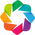

In [162]:
import holoviews as hv
hv.extension('bokeh')
from bokeh.plotting import show

colors = ['#FFA500', '#FF00FF', '#00FFFF', '#FFFF00', '#FF0000']
cmap = ListedColormap(colors)

df_reduced_labels = pd.DataFrame(df_reduced, columns=['UMAP1', 'UMAP2'])
df_reduced_labels['Cluster'] = clusters.astype(str)
# Create and show HoloViews plot
hv_points = hv.Points(df_reduced_labels, ['UMAP1', 'UMAP2'], ['Cluster'])
hv_points.opts(
    opts.Points(
        color='Cluster',
        cmap=cmap,
        size=0.1,
        tools=['hover'],
        alpha=0.5,
        width=600,
        height=400,
        colorbar=True,
        toolbar='above',
        show_grid=True,
        show_legend=True,
        legend_position='right',
        title=f'UMAP projection of the {n_clusters} clusters identified by Birch',
        xlabel='UMAP1',
        ylabel='UMAP2',
        fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend': 12}
    )
)
# Define the hover tool
hover = HoverTool(tooltips=[('Cluster', '@Cluster')])
# Add the hover tool to the plot
hv_points.opts(tools=[hover])
show(hv.render(hv_points))

In [125]:
# Add UMAP result to the original table
df_raw['UMAP1'] = df_reduced[:, 0]
df_raw['UMAP2'] = df_reduced[:, 1]
df_raw['Cluster'] = clusters


In [126]:
df.head()

,Unnamed: 0,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Neighbors_FirstClosestDistance_Expanded,Neighbors_FirstClosestObjectNumber_Expanded,Neighbors_NumberOfNeighbors_Expanded,Neighbors_PercentTouching_Expanded,Neighbors_SecondClosestDistance_Expanded,Neighbors_SecondClosestObjectNumber_Expanded,Number_Object_Number,UMAP1,UMAP2,Cluster
0,0,1,222,289,147,18,130,1,138.135135,8.990991,...,19.761976,2,5.0,73.308271,76.654564,54,1,-0.931241,4.186393,2
1,1,2,470,625,132,29,107,4,119.774468,16.300000,...,19.761976,1,4.0,75.757576,62.300959,54,2,-0.547598,4.432021,2
2,2,3,181,238,891,22,874,8,881.972376,14.176796,...,21.278161,16,4.0,68.725869,28.305380,26,3,-1.026772,4.185467,2
3,3,4,306,396,1044,27,1026,5,1034.408497,15.379085,...,18.598267,17,4.0,65.465465,61.751120,56,4,-0.861204,4.239202,2
4,4,5,194,255,770,23,755,6,761.855670,14.175258,...,23.753242,7,4.0,68.556701,42.579682,8,5,-0.997644,4.152092,2


In [128]:
# Add dosage and CellType from df_metadata table
# df_metadata table has the following columns: ImageNumber, CellType, Dose
# df table has ImageNumber and ObjectNumber
# Merge on ImageNumber
df_raw = pd.merge(df_raw, metadata_df, on='ImageNumber', how='left')
df_raw.head()

,Unnamed: 0_x,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,...,OMEROWellId,OMEROImageName,OMEROImageId,ImageSeries,URL_GFP,Frame_GFP,URL_DNA,Frame_DNA,Dose,CellType
0,0,1,1,222,289,147,18,130,1,138.135135,...,361,"METADATA.ome.xml [Well A01, Field #1]",2895,0,omero:iid=2895,0,omero:iid=2895,1,-7.0,MCF7
1,1,1,2,470,625,132,29,107,4,119.774468,...,361,"METADATA.ome.xml [Well A01, Field #1]",2895,0,omero:iid=2895,0,omero:iid=2895,1,-7.0,MCF7
2,2,1,3,181,238,891,22,874,8,881.972376,...,361,"METADATA.ome.xml [Well A01, Field #1]",2895,0,omero:iid=2895,0,omero:iid=2895,1,-7.0,MCF7
3,3,1,4,306,396,1044,27,1026,5,1034.408497,...,361,"METADATA.ome.xml [Well A01, Field #1]",2895,0,omero:iid=2895,0,omero:iid=2895,1,-7.0,MCF7
4,4,1,5,194,255,770,23,755,6,761.855670,...,361,"METADATA.ome.xml [Well A01, Field #1]",2895,0,omero:iid=2895,0,omero:iid=2895,1,-7.0,MCF7


In [134]:
# Count number of each Cluster label for each CellType and Dose
df_cluster_count = df_raw.groupby(['CellType', 'Dose', 'Cluster']).count()

In [135]:
df_cluster_count.head()

Unnamed: 0_x  ImageNumber  ObjectNumber  \
CellType Dose  Cluster                                            
A549     -13.0 0                  47           47            47   
               1                1091         1091          1091   
               2                 456          456           456   
               3                 148          148           148   
         -12.0 0                  57           57            57   

                        AreaShape_Area  AreaShape_BoundingBoxArea  \
CellType Dose  Cluster                                              
A549     -13.0 0                    47                         47   
               1                  1091                       1091   
               2                   456                        456   
               3                   148                        148   
         -12.0 0                    57                         57   

                        AreaShape_BoundingBoxMaximum_X  \
CellType Dose  Cluster                                   
A549     -13.0 0                                    47   
               1                                  1091   
               2                                   456   
               3                                   148   
         -12.0 0                                    57   

                        AreaShape_BoundingBoxMaximum_Y  \
CellType Dose  Cluster                                   
A549     -13.0 0                                    47   
               1                                  1091   
               2                                   456   
               3                                   148   
         -12.0 0                                    57   

                        AreaShape_BoundingBoxMinimum_X  \
CellType Dose  Cluster                                   
A549     -13.0 0                                    47   
               1                                  1091   
               2                                   456   
               3                                   148   
         -12.0 0                                    57   

                        AreaShape_BoundingBoxMinimum_Y  AreaShape_Center_X  \
CellType Dose  Cluster                                                       
A549     -13.0 0                                    47                  47   
               1                                  1091                1091   
               2                                   456                 456   
               3                                   148                 148   
         -12.0 0                                    57                  57   

                        ...  OMEROPlateId  WellLabel  OMEROWellId  \
CellType Dose  Cluster  ...                                         
A549     -13.0 0        ...            47         47           47   
               1        ...          1091       1091         1091   
               2        ...           456        456          456   
               3        ...           148        148          148   
         -12.0 0        ...            57         57           57   

                        OMEROImageName  OMEROImageId  ImageSeries  URL_GFP  \
CellType Dose  Cluster                                                       
A549     -13.0 0                    47            47           47       47   
               1                  1091          1091         1091     1091   
               2                   456           456          456      456   
               3                   148           148          148      148   
         -12.0 0                    57            57           57       57   

                        Frame_GFP  URL_DNA  Frame_DNA  
CellType Dose  Cluster                                 
A549     -13.0 0               47       47         47  
               1             1091     1091       1091  
               2              456      456     

In [136]:
# Count number of each Cluster label for each CellType and Dose and drop all other columns
df_cluster_counts = df_raw.groupby(['CellType', 'Dose', 'Cluster'])['ObjectNumber'].count().reset_index()
# Create a stacked bar chart of the counts per Cluster vs. Dose for each CellType
hv_cluster_counts = hv.Bars(df_cluster_counts, ['Dose', 'Cluster'], 'ObjectNumber', label='Cluster')


In [137]:
hv_cluster_counts.opts(
    opts.Bars(
        stacked=True,
        cmap=cmap,
        width=800,
        height=600,
        colorbar=True,
        toolbar='above',
        show_grid=True,
        show_legend=True,
        legend_position='right',
        title=f'Cluster counts per dose for each CellType',
        xlabel='Dose',
        ylabel='Cluster counts',
        fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend': 12}
    )
)
show(hv.render(hv_cluster_counts))